In [1]:
import mpmath

In [2]:
mpmath.mp.dps = 100

In [3]:
print(mpmath.mp)

Mpmath settings:
  mp.prec = 336               [default: 53]
  mp.dps = 100                [default: 15]
  mp.trap_complex = False     [default: False]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import pyjet
import time
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

from matching import matching

plt.style.use("scientific.mplstyle")

file = uproot.open("/eos/user/c/clange/PFNano/myNanoProdMc_NANO.root")
event_tree = file['Events']

In [5]:
max_idx = 200

pts = event_tree['PF_pt'].array(entry_stop=max_idx, library='np')
etas = event_tree['PF_eta'].array(entry_stop=max_idx, library='np')
phis = event_tree['PF_phi'].array(entry_stop=max_idx, library='np')
masses = event_tree['PF_mass'].array(entry_stop=max_idx, library='np')

pf_recojetidx = event_tree['PF_jetsIdx'].array(entry_stop=max_idx, library='np')

In [6]:
np_cos = np.frompyfunc(mpmath.cos, 1, 1)
np_sin = np.frompyfunc(mpmath.sin, 1, 1)
np_cosh = np.frompyfunc(mpmath.cosh, 1, 1)
np_sinh = np.frompyfunc(mpmath.sinh, 1, 1)
np_arctan2 = np.frompyfunc(mpmath.atan2, 2, 1)
np_log = np.frompyfunc(mpmath.log, 1, 1)

In [7]:
def ak_sum4vec(pt, eta, phi, mass):
    vec4 = ak.zip({"pt": pt, "eta": eta, "phi": phi, "mass": mass}, with_name="PtEtaPhiMLorentzVector")
    summe = ak.zip({"pt": [0], "eta": [0], "phi": [0], "mass": [0]}, with_name="PtEtaPhiMLorentzVector")
    
    for elm in vec4:
        summe = summe.add(elm)
        
    return summe



def CosTheta(x, y, z):
    '''Find angle theta between z axis and cartesian 3 vector'''
    mag = np.sqrt(x**2+y**2+z**2)
    if mag == 0.0:
        costheta = 1
    else:
        costheta = z/mag
        
    return costheta


def get_pt(x, y):
    '''Find pt as polar radial distance from z axis'''
    return np.sqrt(x**2+y**2)


def get_eta(x, y, z):
    '''Find pesudo rapidity from cartesian 3 vector'''
    cosTheta = CosTheta(x, y, z)
    if cosTheta**2 < 1:
        eta = -0.5*np.log((1.0-cosTheta)/(1.0+cosTheta))
    elif z == 0:
        eta = 0
    elif z > 0:
        eta = 10e10
    else:
        eta = -10e10
        
    return eta


def get_phi(x, y):
    '''Find polar angle phi from cartesian 4 vector'''
    if (x==0) and (y==0):
        phi = 0
    else:
        phi = np_arctan2(y,x)
        
    return phi


def get_m(x, y, z, t):
    '''Find invariant mass from cartesian 4 vector'''
    delta_s2 = t**2 - (x**2 + y**2 + z**2)
    if delta_s2 < 0:
        m = -np.sqrt(-delta_s2)
    else:
        m = np.sqrt(delta_s2)
        
    return m


def np_sum4vec(pt, eta, phi, mass):
    '''Takes in 4 1D np.arrays as componnents of len(pt)-many PtEtaPhiM 4 vectors and returns the sum of these 4 vectors
    as a np.array of length 4 with elements in order of: Pt, Eta, Phi, Mass.'''
    
    # make 4 vector based on ROOT TLorentzVector::SetPtEtaPhiM, which allows element wise sumation
    n_PF = len(pt)
    vec4 = np.ndarray((n_PF,4))
    
    vec4[:,0] = pt*np_cos(phi)
    vec4[:,1] = pt*np_sin(phi)
    vec4[:,2] = pt*np_sinh(eta)
    
    non_neg = np.sqrt(pt**2*np_cosh(eta)**2 + mass**2)
    neg = np.sqrt(np.maximum(pt**2*np_cosh(eta)**2 - mass**2, mpmath.mpf('0')))
    vec4[:,3] = np.where(mass>=0, non_neg, neg)

    vec4_summed = np.sum(vec4, axis=0)
    
    # extract pt, eta, phi, mass from cartesian 4 vector based on ROOT TLorentzVector::Pt, Eta, Phi, M
    sum_PtEtaPhiM = np.empty(4)
    sum_PtEtaPhiM[0] = get_pt(vec4_summed[0], vec4_summed[1])
    sum_PtEtaPhiM[1] = get_eta(vec4_summed[0], vec4_summed[1], vec4_summed[2])
    sum_PtEtaPhiM[2] = get_phi(vec4_summed[0], vec4_summed[1])
    sum_PtEtaPhiM[3] = get_m(vec4_summed[0], vec4_summed[1], vec4_summed[2], vec4_summed[3])
    
    
    return sum_PtEtaPhiM

In [8]:
# # compare sums
# print("{0: <20} {1: >10} {2: >10} {3: >10} {4: >10}".format("sum type", "pt", "eta", "phi", "mass"))
# for i in range(1):
#     print(f"event {i} --------")
#     for j in np.unique(pf_recojetidx[i])[1:]:
#         consti_mask = np.where(pf_recojetidx[i]==j)[0]
#         ak_sum = ak_sum4vec(pts[i][consti_mask], etas[i][consti_mask], phis[i][consti_mask], masses[i][consti_mask])
#         np_sum = np_sum4vec(pts[i][consti_mask], etas[i][consti_mask], phis[i][consti_mask], masses[i][consti_mask])
#         print(f"Jet: {j}")
#         print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}".format("ak sum", ak_sum.pt[0], ak_sum.eta[0], ak_sum.phi[0], ak_sum.mass[0]))
#         print("{0: <20} {1: 10.3f} {2: 10.3f} {3: 10.3f} {4: 10.3f}".format("np sum", np_sum[0], np_sum[1], np_sum[2], np_sum[3]))
#         print("\n")

In [9]:
ak_pt, ak_eta, ak_phi, ak_m = [], [], [], []

t1 = time.time()
for i in range(max_idx):
    for j in np.unique(pf_recojetidx[i])[1:]:
        consti_mask = np.where(pf_recojetidx[i]==j)[0]
        ak_sum = ak_sum4vec(pts[i][consti_mask], etas[i][consti_mask], phis[i][consti_mask], masses[i][consti_mask])
        
        ak_pt.append(ak_sum.pt[0])
        ak_eta.append(ak_sum.eta[0])
        ak_phi.append(ak_sum.phi[0])
        ak_m.append(ak_sum.mass[0])
        
t2 = time.time()
print("AK sum: {}".format(t2-t1))
        
        
        
np_pt, np_eta, np_phi, np_m = [], [], [], []

t = 0
for i in range(max_idx):
    for j in np.unique(pf_recojetidx[i])[1:]:
        consti_mask = np.where(pf_recojetidx[i]==j)[0]
        pt = np.array([mpmath.mpf(str(p)) for p in pts[i][consti_mask]])
        eta = np.array([mpmath.mpf(str(e)) for e in etas[i][consti_mask]])
        phi = np.array([mpmath.mpf(str(p)) for p in phis[i][consti_mask]])
        m = np.array([mpmath.mpf(str(m)) for m in masses[i][consti_mask]])
        t3 = time.time()
        np_sum = np_sum4vec(pt, eta, phi, m)
        t4 = time.time()
        t += t4-t3
        np_pt.append(np_sum[0])
        np_eta.append(np_sum[1])
        np_phi.append(np_sum[2])
        np_m.append(np_sum[3])
        

print("NP sum: {}".format(t))


d_pt = np.asarray(np_pt) - np.asarray(ak_pt)
d_eta = np.asarray(np_eta) - np.asarray(ak_eta)
d_phi = np.asarray(np_phi) - np.asarray(ak_phi)
d_m = np.asarray(np_m) - np.asarray(ak_m)

AK sum: 135.38720417022705
NP sum: 10.430126905441284


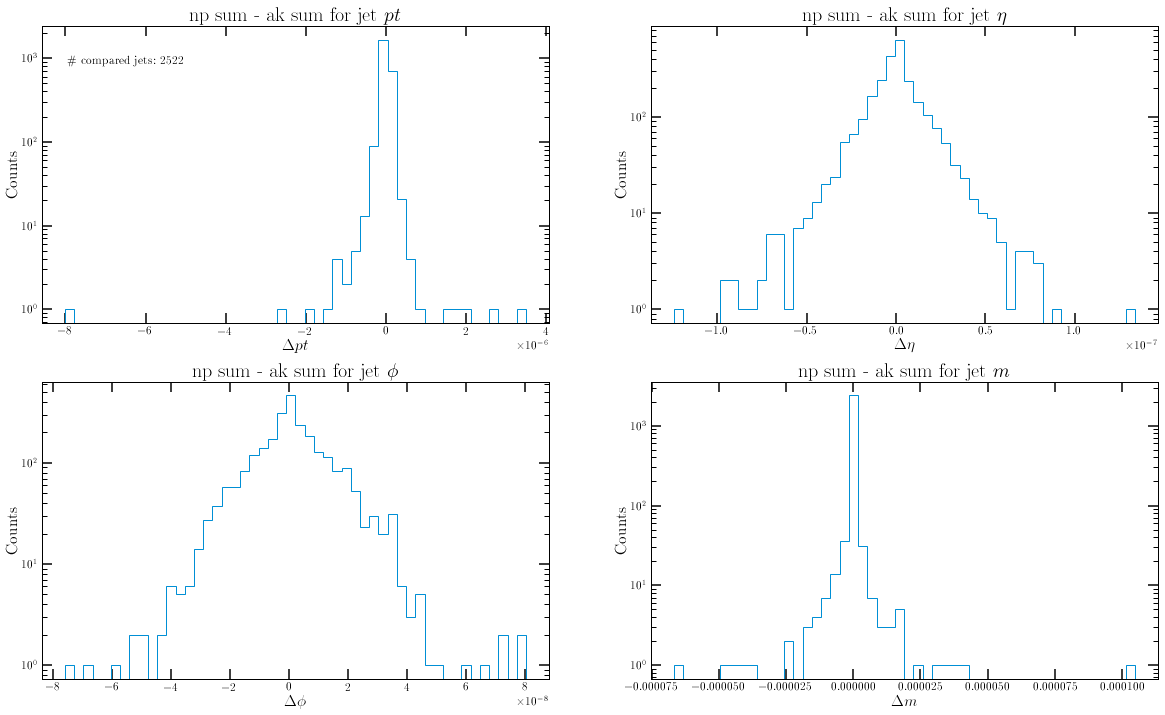

In [38]:
fig, ax = plt.subplots(2,2, figsize=(20, 12))
plt.rcParams.update({'font.size': 12})

ax[0][0].hist(d_pt, bins=50, histtype='step')
ax[0][0].text(0.05, 0.9, "\# compared jets: {:.0f}".format(len(d_pt)), ha='left', va='top', transform = ax[0][0].transAxes)
#ax[0][0].text(0.05, 0.9, "\# compared jets: {:.0f}\n Run time for np sum: {:.3f} sec".format(len(d_pt), t4-t3), ha='left', va='top', transform = ax[0][0].transAxes)
ax[0][0].set_title('np sum - ak sum for jet $pt$')
ax[0][0].set_yscale('log')
ax[0][0].set_xlabel("$\Delta pt$")
ax[0][0].set_ylabel('Counts')

ax[0][1].hist(d_eta, bins=50, histtype='step')
ax[0][1].set_title('np sum - ak sum for jet $\eta$')
ax[0][1].set_yscale('log')
ax[0][1].set_xlabel("$\Delta \eta$")
ax[0][1].set_ylabel('Counts')

ax[1][0].hist(d_phi, bins=50, histtype='step')
ax[1][0].set_title('np sum - ak sum for jet $\phi$')
ax[1][0].set_yscale('log')
ax[1][0].set_xlabel("$\Delta \phi$")
ax[1][0].set_ylabel('Counts')

ax[1][1].hist(d_m, bins=50, histtype='step')
ax[1][1].set_title('np sum - ak sum for jet $m$')
ax[1][1].set_yscale('log')
ax[1][1].set_xlabel("$\Delta m$")
ax[1][1].set_ylabel('Counts')


plt.show()
#fig.savefig("plots/np_4vect_sum_accuracy_dps100.pdf")